# Stocks and Portfolio Analysis

Sample of possible analysis that we can do for individual stocks or portfolios

In [117]:
stocks = ['TSLA', 'RBLX', 'GOEV','GOOG','SHOP']

### Importing libraries

In [116]:
import pandas as pd
import numpy as np
import edhec_risk_kit as edhc 
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('fivethirtyeight')

### Collecting Data

In [7]:
data = edhc.portfolio_data(stocks)

## Data Visualization

### Historical Return

<AxesSubplot:title={'center':'Historical Performance'}, xlabel='Date'>

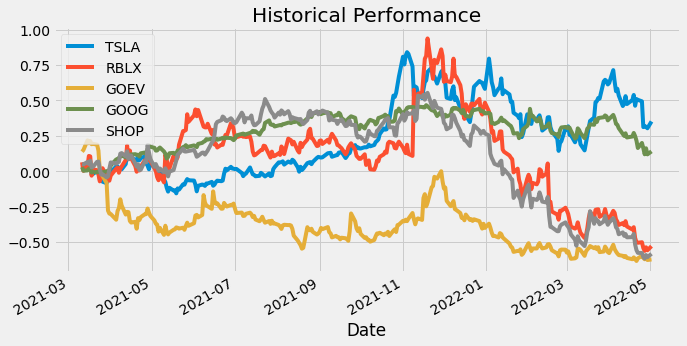

In [24]:
#data.apply(lambda x: np.expm1(np.log1p(x).sum()))
accum_return = data.apply(lambda x: np.expm1(np.log1p(x).cumsum()))
accum_return.plot(title = "Historical Performance", figsize = (10,5))

### Historical Distribution of the Returns


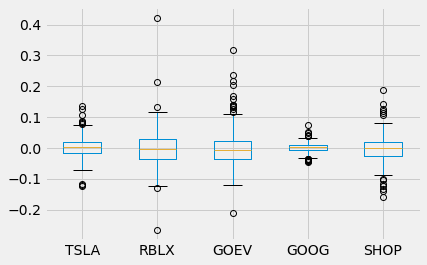

In [33]:
p = data.boxplot()

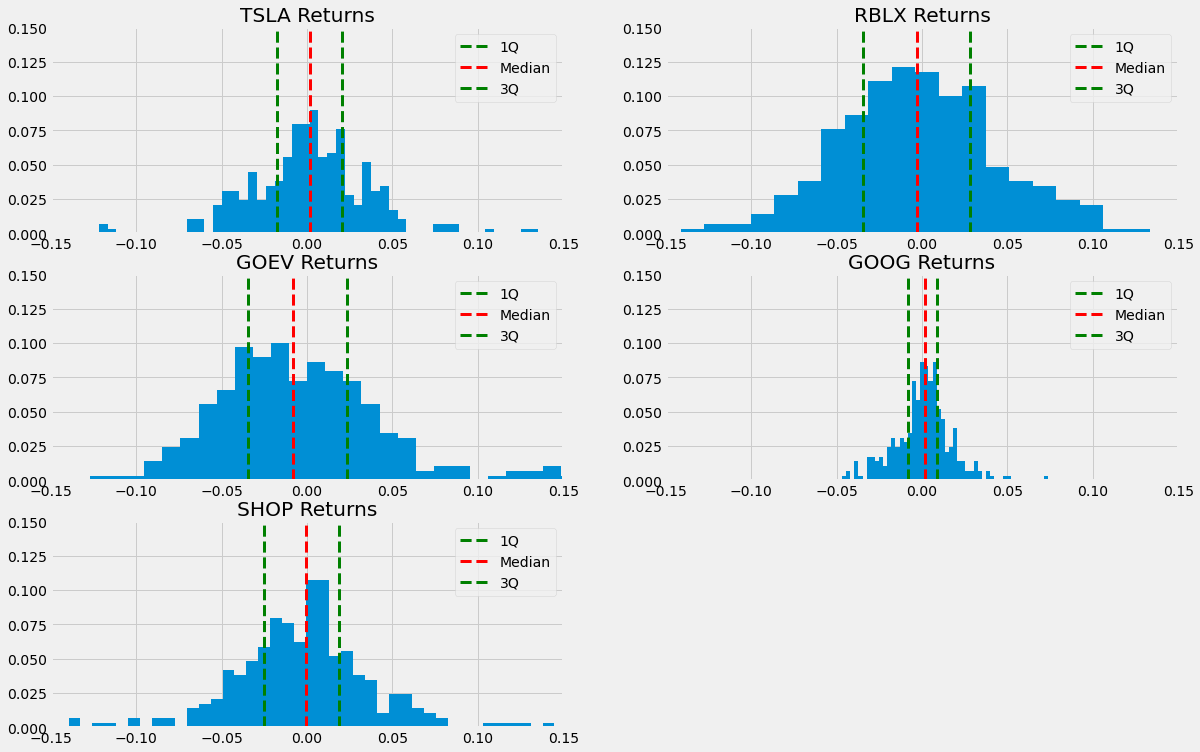

In [85]:
plt.figure(figsize=(18, 12))

labels = ['1Q', 'Median', '3Q']
colours = ['green', 'red', 'green']

i = 1
for column in data:

    plt.subplot(int(f'32{i}')).hist(data[column],weights= np.ones(data.shape[0]) / data.shape[0], bins = 50, )
    plt.xlim(( -0.15, 0.15))
    plt.ylim(( 0, 0.15))
    plt.title(column + ' Returns')
    quantiles = np.quantile(data[column],[0.25, 0.5, 0.75])
    for k in range(3):
        plt.axvline(x=quantiles[k], color = colours[k], label = labels[k], linestyle = "dashed", linewidth = 3 )
    plt.legend()
    i = 1 + i

## Numerical Indicators for the Stocks

Using the ETF Tip as a proxy to compute the annualized interest rate for the period

In [118]:
tip = yf.Ticker('TIP').history(period="max").Close.pct_change().dropna()
interest_rate = edhc.annualize_rets(tip, periods_per_year = 252)
print(f'Interest Rate for the Period {round(interest_rate*100, 3)}%')

Interest Rate for the Period 3.901%


Getting the data that will represent the Market. We are going to use the ETF IVV as a proxy.

In [210]:
ivv = yf.Ticker('IVV').history(period="max").Close.pct_change().dropna()

df = pd.concat([data, ivv], axis = 1, ).dropna()
df.columns = list(data.columns)+['Market']
market = df['Market']

### Computing the Indicators

Here we are going to compute some basic numerical indicators for the past performance.

In [208]:
from sklearn.linear_model import LinearRegression

def summary_stats(r, market, riskfree_rate=0.03, ):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    
    def model(y, x):
        '''
        Function that will compute the linear regression for the data
        '''
        ind = x.values.reshape((-1, 1))
        dep = y
        linModel = LinearRegression().fit(ind, dep)
        #Note, as we are working with daily data, this alpha in daily format
        #For converting it to annualized format, we need exponentiate it to 12
        alpha = (linModel.intercept_+1)**12-1
        return (alpha, linModel.coef_[0])

    ann_r = r.aggregate(edhc.annualize_rets, periods_per_year=252)
    ann_vol = r.aggregate(edhc.annualize_vol, periods_per_year=252)
    ann_sr = r.aggregate(edhc.sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=252)
    dd = r.aggregate(lambda r: edhc.drawdown(r).Drawdown.min())
    skew = r.aggregate(edhc.skewness)
    kurt = r.aggregate(edhc.kurtosis)
    cf_var5 = r.aggregate(edhc.var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(edhc.cvar_historic)
    models = data.aggregate(model, x=market)
    
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd,
        'Beta' : models.iloc[1],
        'Alpha' : models.iloc[0]
    })

In [209]:
summary_stats(data, market, interest_rate)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,Beta,Alpha
TSLA,0.300445,0.547679,0.050945,4.918335,0.053180,0.071034,0.459447,-0.378784,1.722533,0.013030
RBLX,-0.482092,0.888858,1.317766,15.238910,0.056464,0.109155,-0.564342,-0.774644,1.936919,-0.020403
GOEV,-0.573580,0.906713,1.392847,8.431440,0.064701,0.096445,-0.650338,-0.700000,1.925426,-0.028869
GOOG,0.121205,0.263749,0.133069,4.506315,0.025553,0.035398,0.299954,-0.237162,1.305115,0.002038
SHOP,-0.534193,0.666959,0.135436,5.852510,0.067089,0.098699,-0.827267,-0.753815,2.340285,-0.034263
